In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from konlpy.tag import Kkma
from konlpy.utils import pprint

Using TensorFlow backend.


In [2]:
# Init files

train_file_name = 'train'
test_file_name = 'test'

full_dir_format = 'dataset_1/{}.txt'
processed_file_dir_format = 'dataset_1/processed_{}.txt'

train_file_dir = full_dir_format.format(train_file_name)
test_file_dir = full_dir_format.format(test_file_name)
processed_train_file_dir = processed_file_dir_format.format(train_file_name)
processed_test_file_dir = processed_file_dir_format.format(test_file_name)
processed_test_file_dir

'dataset_1/processed_test.txt'

In [3]:
# Open files

train_file = open(train_file_dir, 'r', encoding='utf8')
processed_train_file = open(processed_train_file_dir, 'r+', encoding='utf8')

test_file = open(test_file_dir, 'r', encoding='utf8')
processed_test_file = open(processed_test_file_dir, 'r+', encoding='utf8')

In [4]:
# Preprocess files

for line in train_file:
    processed_train_file.write(line.replace('\t', '\s', line.count('\t') - 1))

train = pd.read_csv(processed_train_file, delimiter='\t', header=None, names=['comment_text', 'type'])
    
for line in test_file:
    processed_test_file.write(line.replace('\t', '\s', line.count('\t') - 1))

test = pd.read_csv(processed_test_file, delimiter='\t', header=None, names=['comment_text', 'type'])

In [5]:
# Check files (1/2)
train.head()
test.head()

,comment_text,type
0,http://gohnk.tistory.com 요즘 남편몰래 바람피는 여편내들 왜이렇...,spam
1,대구맘 http://cafe.naver.com/velobike대구에서 살고 있는 엄...,spam
2,대구맘 http://cafe.naver.com/velobike대구에서 살고 있는 엄...,spam
3,http://m.cafe.naver.com/evolutionpt남성연애 커뮤니티.모...,spam
4,http://m.cafe.naver.com/evolutionpt모쏠이신분! 연애경험...,spam


In [6]:
# Check files (2/2)
train.isnull().any()

comment_text    False
type            False
dtype: bool

In [7]:
# Change categorical to index codes
train['type'] = pd.Categorical(train['type'])
test['type'] = pd.Categorical(test['type'])

# Y is in [0, 1] where 1 is spam and 0 is normal
y_t = train['type'].astype('category').cat.codes
y_te = test['type'].astype('category').cat.codes

# Get list of comments
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [8]:
# Tokenize the comments

max_features = 20000
tokenizer = Tokenizer(num_words=max_features, char_level=True)

tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [9]:
# See occurence of words
# tokenizer.word_counts['했']

In [10]:
# Index of words
# tokenizer.word_index['했']


In [11]:
# Tokenized sentence
# list_tokenized_train[:1]

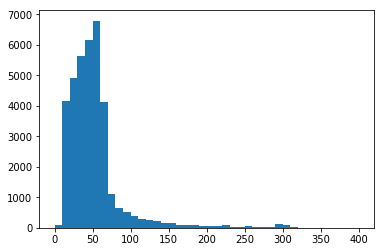

In [12]:
# See distribution of length of comments length

totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [13]:
# Pad sequences

maxlen = 300
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
X_te[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [14]:
# Input layer

inp = Input(shape=(maxlen, ))

In [15]:
# Embed layer

embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [16]:
# LSTM layer

x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

In [17]:
# Max Pooling layer

x = GlobalMaxPool1D()(x)

In [18]:
# Dropout layer (1/2)

x = Dropout(0.1)(x)

In [19]:
# Dense Layer

x = Dense(50, activation="relu")(x)

In [20]:
# Droupout layer (2/2)

x = Dropout(0.1)(x)

In [21]:
# Final Dense layer

x = Dense(1, activation="sigmoid")(x)

In [22]:
# Optimizer

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [23]:
# Train model

batch_size = 32
epochs = 2
model.fit(X_t, y_t, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 32949 samples, validate on 3661 samples
Epoch 1/2
32949/32949 [==============================] - 406s 12ms/step - loss: 0.0661 - acc: 0.9773 - val_loss: 0.0254 - val_acc: 0.9924
Epoch 2/2
32949/32949 [==============================] - 366s 11ms/step - loss: 0.0173 - acc: 0.9955 - val_loss: 0.0079 - val_acc: 0.9981


In [24]:
scores = model.evaluate(X_te, y_te, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

41260/41260 [==============================] - 94s 2ms/step
acc: 59.13%


In [34]:
test_text = "못 보신 분들 \"마이티빙\"에서 무료로 보세요. 가입필요 없음."

tokenized = tokenizer.texts_to_sequences([test_text])

test_sequence = pad_sequences(tokenized, maxlen=maxlen)

model.predict(test_sequence)

array([[0.91281]], dtype=float32)